In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pylatexenc
from qiskit import * #qiskit
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
#from qiskit.extensions import Initialize
from qiskit import QuantumCircuit, QuantumRegister, transpile, transpiler#, assemble#, execute, Aer, BasicAer
from qiskit_aer import Aer
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeTorino,FakeAthensV2,FakeCasablancaV2,FakeGuadalupeV2
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime.fake_provider import fake_backend
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_aer import AerSimulator

from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

from IPython.display import HTML, display
import os
#import ipywidgets as widgets

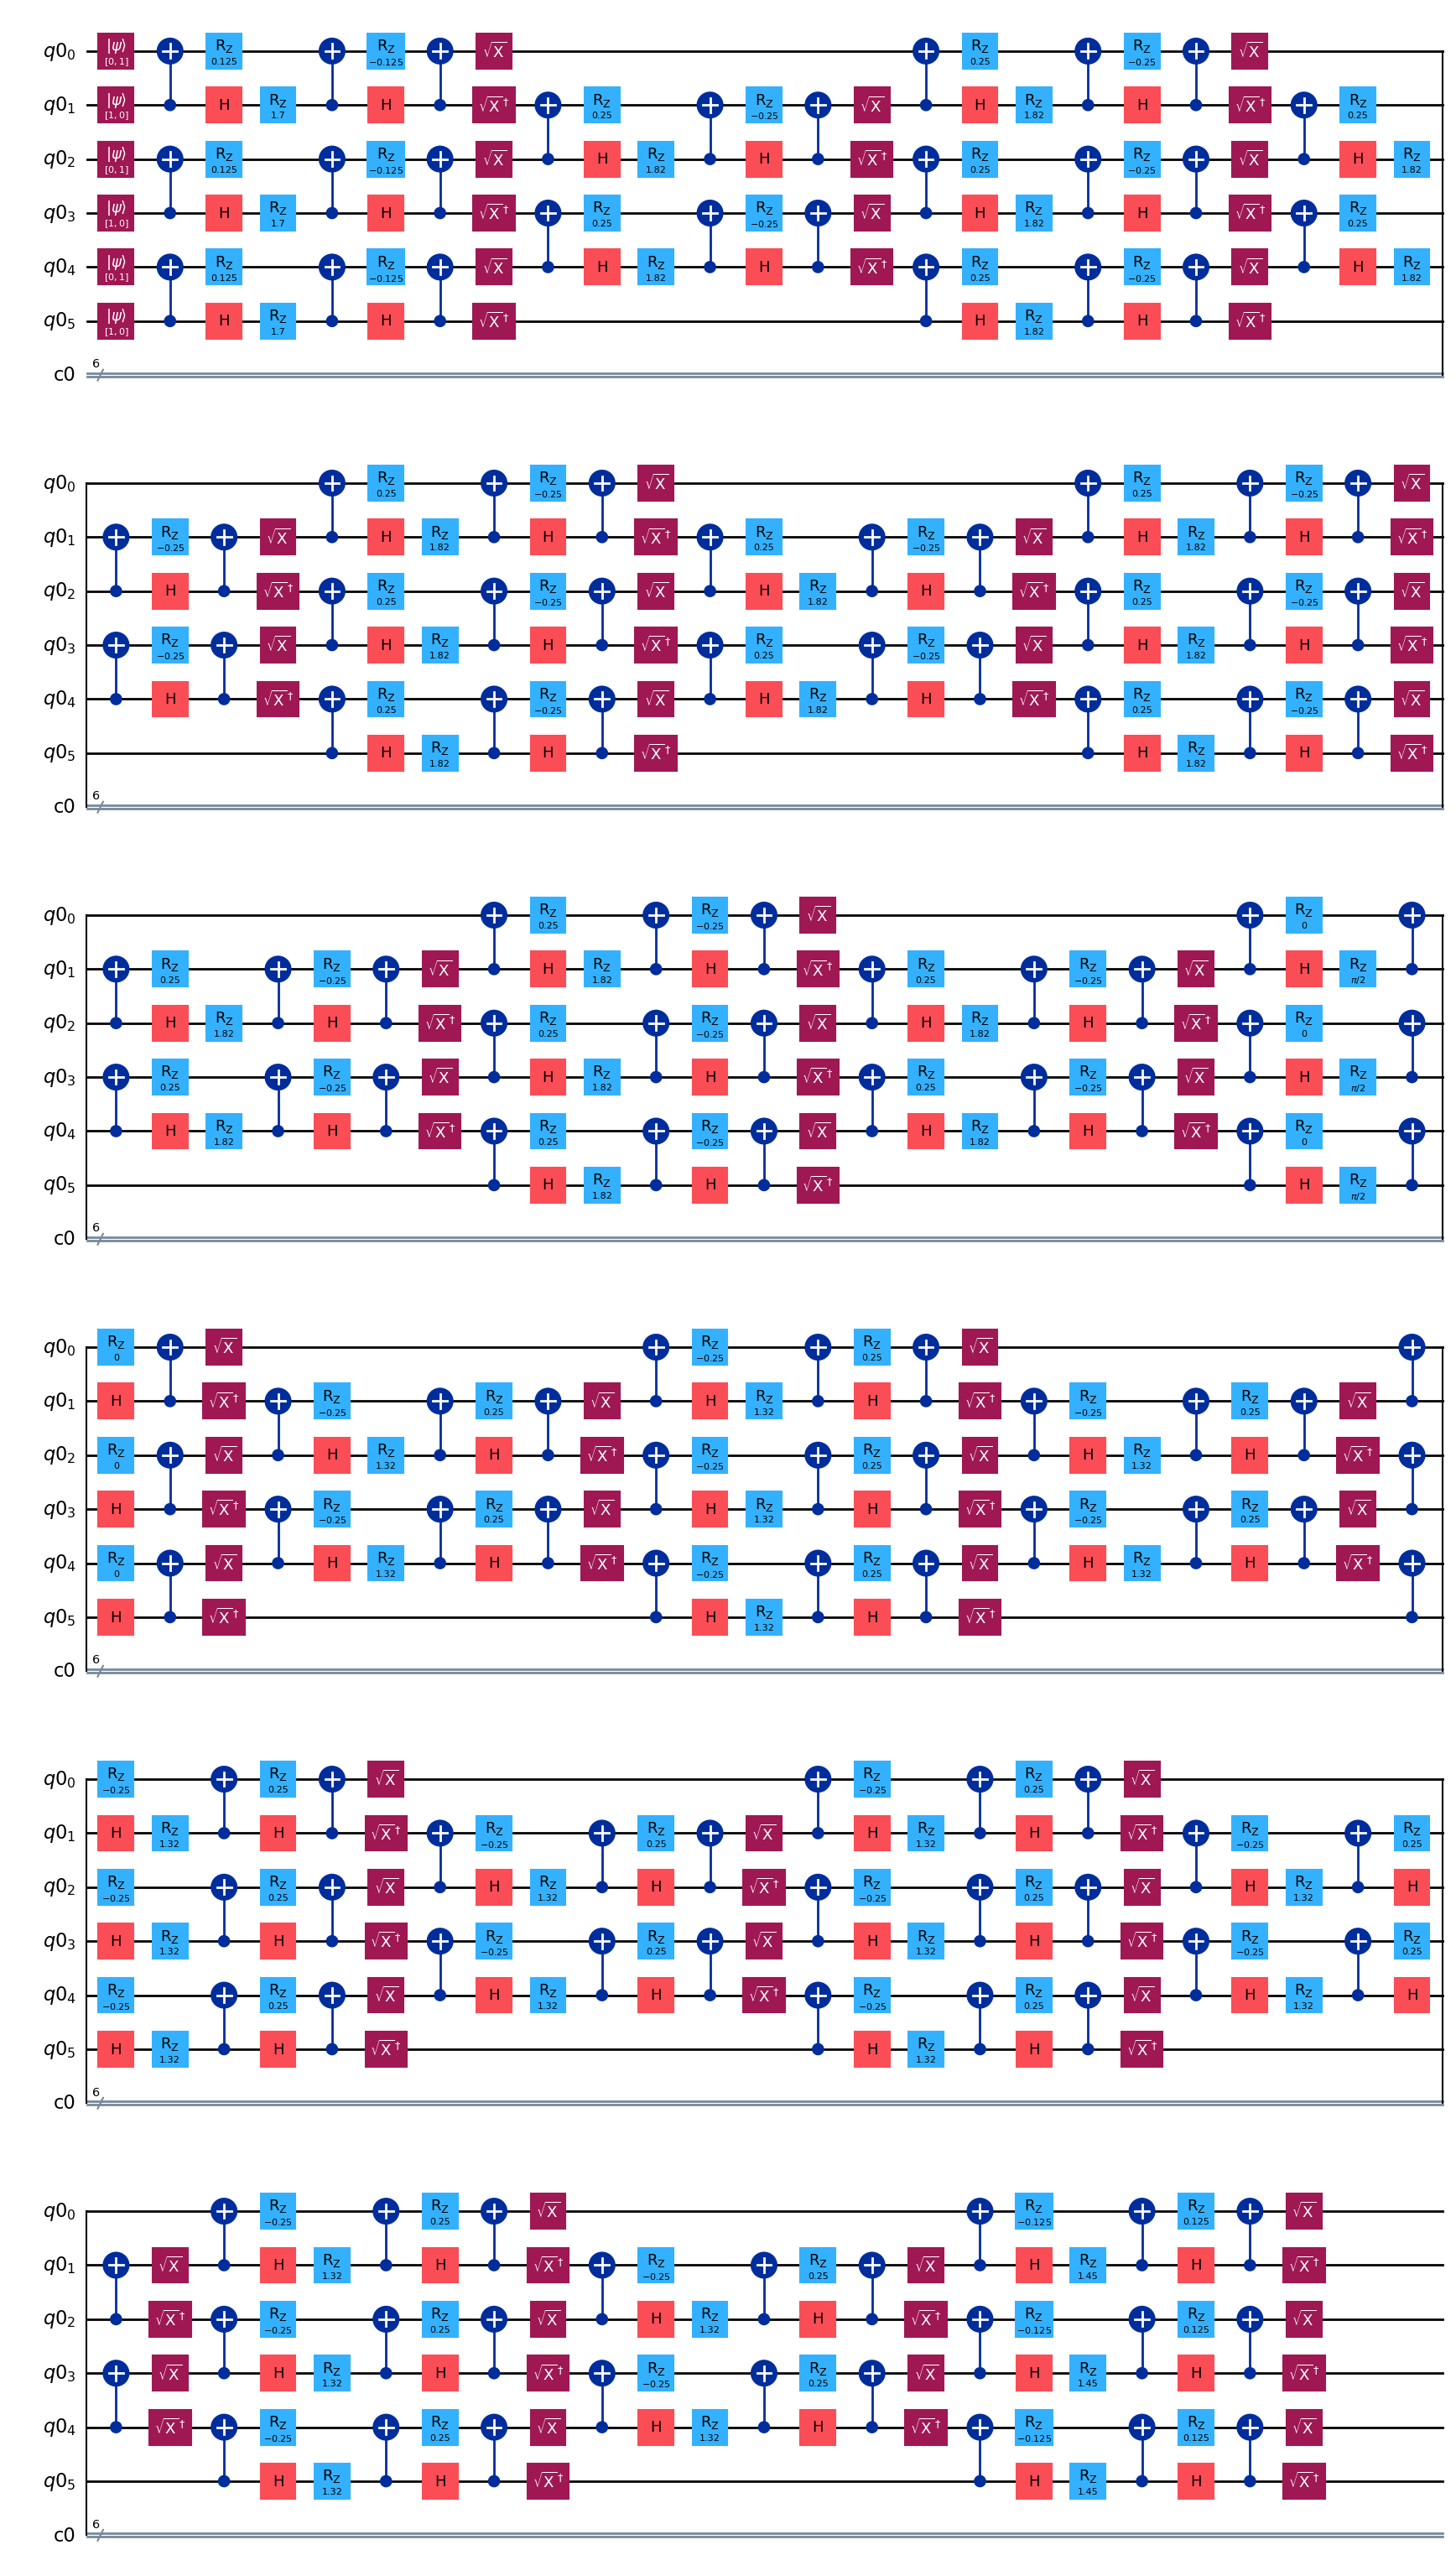

In [2]:
# N = 5 #number of qubits
#t=0.5
#J = 1 #coupling
#dt = 0.5 #time step size
#r=int(t/dt) #number of trotter steps
#delta = 1 #exchange anisotropy

def u(circuit, qubit_1, qubit_2,time,J=1,delta=1):
    circuit.cx(qubit_2,qubit_1)
    circuit.rz(delta*time*J/2,qubit_1)
    circuit.h(qubit_2)
    circuit.rz((np.pi/2)+J*time/2,qubit_2)
    circuit.cx(qubit_2,qubit_1)
    circuit.rz(-J*time/2,qubit_1)
    circuit.h(qubit_2)
    circuit.cx(qubit_2,qubit_1)
    circuit.sx(qubit_1)
    circuit.sxdg(qubit_2)

    

initial=[[0,1],[1,0]] #initialize Neel state

def start(time,step,backend,N=6):
    #initialize circuit
    t0=0
    t1=0
    
    qr0 = QuantumRegister(N) #test circuit
    cr0 = ClassicalRegister(N)
    test = QuantumCircuit(qr0,cr0) #Hamiltonian

    qr1 = QuantumRegister(N) #target circuit
    cr1 = ClassicalRegister(N)
    target_circuit = QuantumCircuit(qr1,cr1)
    
    ts=np.arange(step,time+step,step)
    nl=2*len(ts)+1
    #print(len(ts),nl)
    
    for qubit in range(N): 
        test.initialize(initial[qubit%2],qubit)
        target_circuit.initialize(initial[qubit%2],qubit)
    for i in range(len(ts)):
        #print(2*i,nl//2)
        t0=step
        t1=step
        if i == 0:
            t0=step/2
            t1=step/2
        if (2*i) == nl//2:
            t0=0
        if (2*i) > nl//2:
            t0=-step
        #print(i,t0,t1)
        for n in range(N//2):
            n=2*n
            n1=n+1
            u(test,n,n1,t0)
            u(target_circuit,n,n1,t1)
        #print(i,t0,t1)
        if i == 0:
            t0=step
            t1=step
        if (2*i) == nl//2:
            t0=-step
        for n in range((N//2)-1):
            n=(2*n)+1
            n1=n+1
            u(test,n,n1,t0)
            u(target_circuit,n,n1,t1)
    t0=-step/2
    t1=step/2
    for n in range(N//2):
        n=2*n
        n1=n+1
        u(test,n,n1,t0)
        u(target_circuit,n,n1,t1)

    #initialize observable
    interactions = [("Z", [i], (-1)**(i)*1/(2*N)) for i in range(N)] #ADD factor of 1/2
    magnetization = SparsePauliOp.from_sparse_list(interactions, num_qubits=N)
    
    return test,target_circuit,magnetization

qc0,qc1,obs = start(5,0.5,Aer.get_backend('qasm_simulator'))

qc0.draw('mpl')

In [27]:
step=0.5
n_steps=12
time=step*n_steps
model = NoiseModel.from_backend(FakeAthensV2())
noise=AerSimulator(noise_model=model)
no_noise=Aer.get_backend('qasm_simulator')
estimator0=Estimator(mode=no_noise)
estimator1=Estimator(mode=noise)

ts = np.arange(0,time+step,step)
m0s=[]
m1s=[]
ps=[]

#estimate noise factor
qc0,qc1,obs=start(time,step,no_noise)
m=-0.5
for t in ts:
    qc0,qc1,obs=start(t,step,no_noise)
    for i in range(10):
        job1=estimator1.run([(qc0,obs)])
        m1=job1.result()[0].data.evs
        job0=estimator0.run([(qc0,obs)])
        m0=job0.result()[0].data.evs
        m0s.append(m0)
        m1s.append(m1)
    m0=sum(m0s)/len(m0s)
    m1=sum(m1s)/len(m1s)
    p=1-(m1/m)
    ps.append(p)

#print(m1s)
#print(m0s)
print(ps)

[0.10076497395833339, 0.15653076171875002, 0.17798394097222225, 0.2212809244791668, 0.25082845052083347, 0.29044325086805567, 0.32245861235119055, 0.35984497070312504, 0.39164948640046304, 0.4261197916666668, 0.45626923532196983, 0.4866746690538195, 0.5133419721554489]


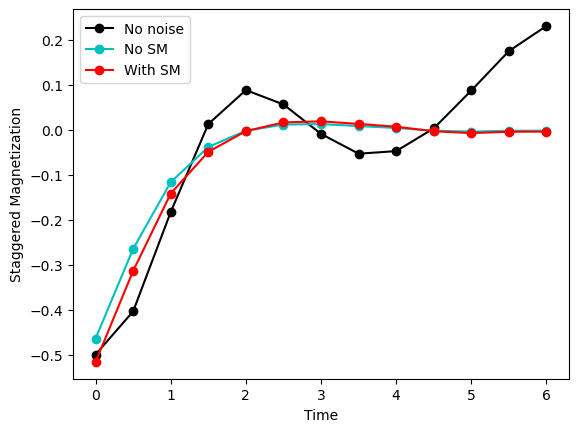

In [29]:
ms0=[] #no noise
ms1=[] #no SM
ms2=[] #with SM
error0=np.array([])
error1=np.array([])
error2=np.array([])

step=0.1

for i in range(len(ts)):
    p=ps[i]
    t=ts[i]
    qc0,qc1,obs=start(t,step,no_noise)
    total0 = np.array([])
    total1 = np.array([]) #no SM
    total2 = np.array([]) #with SM
    for j in range(10):
        job0=estimator0.run([(qc1,obs)])
        job1=estimator1.run([(qc1,obs)])
        result0 = job0.result()
        m0=result0[0].data.evs
        result1 = job1.result()
        m1=result1[0].data.evs
        total0 = np.append(total0,m0)
        total1 = np.append(total1,m1)
        total2 = np.append(total2,m1/(1-p))
    
    ms0.append(np.average(total0))
    error0=np.append(error0,np.std(total0)/np.sqrt(10))
    ms1.append(np.average(total1))
    error1=np.append(error1,np.std(total1)/np.sqrt(10))
    ms2.append(np.average(total2))
    error2=np.append(error2,np.std(total2)/np.sqrt(10))


plt.plot(ts,ms0,'ko-',label='No noise')
plt.plot(ts,ms1,'co-',label='No SM')
plt.plot(ts,ms2,'ro-',label='With SM')
plt.xlabel('Time')
plt.ylabel('Staggered Magnetization')
plt.legend()
plt.savefig('magnetization.png')

Absolute error:
No SM:  1.0550455729166666    With SM:  0.9845190298854102


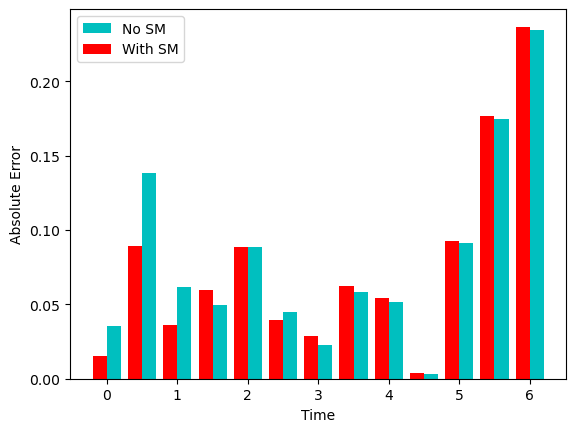

In [11]:
e1=[] #no SM
e2=[] #with SM
total1=0
total2=0
bar_width=0.2
for i in range(len(ts)):
    total1+=abs(ms0[i]-ms1[i])
    total2+=abs(ms0[i]-ms2[i])
    e1.append(abs(ms0[i]-ms1[i]))
    e2.append(abs(ms0[i]-ms2[i]))
plt.bar(ts+bar_width/2,e1,width=bar_width,label='No SM',color='c')
plt.bar(ts-bar_width/2,e2,width=bar_width,label='With SM',color='r')
plt.xlabel('Time')
plt.ylabel('Absolute Error')
plt.legend()
plt.savefig('error.png') 
print("Absolute error:")
print("No SM: ",total1,"   With SM: ",total2)

In [15]:
ms0

[-0.4992594401041666,
 -0.4039388020833332,
 -0.17922363281249998,
 0.0131591796875,
 0.08985188802083331,
 0.05804850260416666,
 -0.009847005208333332,
 -0.05086263020833333,
 -0.047509765625,
 0.003084309895833333,
 0.08875325520833334,
 0.1719807942708333,
 0.23197428385416666]

In [19]:
for i in range(13):
    print(ts[i],"&",round(ps[i],5),"&","\(",round(ms0[i],5),"\pm",round(error0[i],5),"\)","&",
         "\(",round(ms1[i],5),"\pm",round(error1[i],5),"\)","&",
         "\(",round(ms2[i],5),"\pm",round(error2[i],5),"\)","\\\\")

0.0 & 0.09935 & \( -0.49926 \pm 7e-05 \) & \( -0.46357 \pm 0.0005 \) & \( -0.51471 \pm 0.00055 \) \\
0.5 & 0.15706 & \( -0.40394 \pm 0.00085 \) & \( -0.2655 \pm 0.00083 \) & \( -0.31497 \pm 0.00099 \) \\
1.0 & 0.17759 & \( -0.17922 \pm 0.00123 \) & \( -0.11753 \pm 0.00109 \) & \( -0.1429 \pm 0.00133 \) \\
1.5 & 0.22099 & \( 0.01316 \pm 0.0014 \) & \( -0.0364 \pm 0.00063 \) & \( -0.04672 \pm 0.00081 \) \\
2.0 & 0.25093 & \( 0.08985 \pm 0.00087 \) & \( 0.00099 \pm 0.00054 \) & \( 0.00132 \pm 0.00072 \) \\
2.5 & 0.2908 & \( 0.05805 \pm 0.00135 \) & \( 0.01335 \pm 0.00104 \) & \( 0.01883 \pm 0.00146 \) \\
3.0 & 0.32231 & \( -0.00985 \pm 0.00199 \) & \( 0.01298 \pm 0.00107 \) & \( 0.01915 \pm 0.00158 \) \\
3.5 & 0.35907 & \( -0.05086 \pm 0.0011 \) & \( 0.00738 \pm 0.0007 \) & \( 0.01152 \pm 0.00109 \) \\
4.0 & 0.3908 & \( -0.04751 \pm 0.00124 \) & \( 0.00422 \pm 0.00127 \) & \( 0.00692 \pm 0.00208 \) \\
4.5 & 0.42532 & \( 0.00308 \pm 0.0008 \) & \( -0.00034 \pm 0.00113 \) & \( -0.00059 \pm 

<>:2: SyntaxWarning: invalid escape sequence '\('
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\)'
<>:3: SyntaxWarning: invalid escape sequence '\('
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\)'
<>:4: SyntaxWarning: invalid escape sequence '\('
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\)'
<>:2: SyntaxWarning: invalid escape sequence '\('
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\)'
<>:3: SyntaxWarning: invalid escape sequence '\('
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\)'
<>:4: SyntaxWarning: invalid escape sequence '\('
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\)'
C:\Users\Eddie\AppData\Local\Temp\ipykernel_39904\4034211293.py:2: SyntaxWarning: invalid escape seq

In [82]:
x=np.append(x,4)
x

array([1, 2, 3, 4])

In [84]:
np.array([])

array([], dtype=float64)

In [90]:
np.sum(x)

10

In [107]:
round(4.00356,4)

4.0036